In [1]:
import numpy as np
from numpy import kron, sqrt, pi, arccos, cos, sin, exp
from numpy.linalg import norm
from numpy.linalg import matrix_power, eig
from scipy.linalg import expm
from copy import deepcopy
import functools as ft

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1, 0], [0, 1]])

def spectral_norm(U0):
    return np.linalg.norm(U0, ord=2)

def commutator(A, B):
    return A@B - B@A

def local_interaction(n, dict):
    R_list = [I] * n
    for i in dict:
        R_list[i] = dict[i]
    return ft.reduce(kron, R_list)

def neighbor_heisenberg(n_qubit):
    edges = []
    for i in range(n_qubit-1):
        edges.append((i, i+1))    
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    edges.append((0, n_qubit-1))

    for i, j in edges:
        XX += local_interaction(n_qubit, {i:X, j:X})
        YY += local_interaction(n_qubit, {i:Y, j:Y})
        ZZ += local_interaction(n_qubit, {i:Z, j:Z})
        ZZ += local_interaction(n_qubit, {i:Z, j:I}) * 0.2
    return [XX, YY, ZZ]

def sum_second_order_commutator_norm(H_list):
    sum = 0
    n = len(H_list)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_3 in range(gamma_1+1, n):
            for gamma_2 in range(gamma_1+1, n):
                R += commutator(H_list[gamma_3], commutator(H_list[gamma_2], H_list[gamma_1])) / 12
        sum += spectral_norm(R)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_2 in range(gamma_1+1, n):
            R += commutator(H_list[gamma_1], commutator(H_list[gamma_1], H_list[gamma_2])) / 24
        sum += spectral_norm(R)
    return sum

def near_diagonal(R, eigenvalues, eps):
    N = R.shape[0]
    # print(N)
    R_copy = deepcopy(R)
    for i in range(N):
        for j in range(N):
            if abs(eigenvalues[i] - eigenvalues[j]) > eps:
                R_copy[i][j] = 0
    return R_copy

H_tmp = []
def trotter_simulation(H_list, n, T, r):
    U1 = np.eye(2 ** n).astype(np.complex128)
    # print(H_list, T, r)
    for H in H_list:
        H_tmp.append(-1.0j * H * T / r)
        U1 = U1 @ expm(-1.0j * H * T / r)
    return matrix_power(U1, r)

def trotter_error(H_list, n_qubit, T, r):
    U_target = expm(-1.0j* sum(H_list) * T)
    U_impl = trotter_simulation(H_list, n_qubit, T, r)
    return spectral_norm(U_impl - U_target)

def interference_bound_new(R, H, T, eps):
    N = R.shape[0]
    eigenvalues, eigenvectors = eig(H)
    R_norm = spectral_norm(R)
    delta_norm = spectral_norm(near_diagonal(R, eigenvalues, eps)) # eps refers to the spectral gap
    resid_norm = spectral_norm(R-near_diagonal(R, eigenvalues, eps))
    # print(R_norm, delta_norm, resid_norm)
    return (resid_norm *  (1 / (eps * T)) + delta_norm) 

def interference_bound_new2(R, H, T):
    eigenvalues, eigenvectors = eig(H)
    near_norm = {}
    for i in range(-10, 5):        
        if i==-10:
            near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i))
        else:
            near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))
    interference_R = 0
    for i in range(-10, 5):
        interference_R += near_norm[i] * min(1, 1/(T*(2**i)))
    return interference_R
        

{100: 1.9997416951255191, 127: 1.9999644892245962, 161: 1.9999962567833276, 204: 1.998345037952989, 259: 1.9606065105962773, 329: 1.5764467495684724, 418: 1.1208574214791815, 530: 0.764101784176543, 672: 0.5159941354024334, 853: 0.35135686482046397, 1083: 0.25487059657972955, 1374: 0.18797542453604565, 1743: 0.14056302205032123, 2212: 0.10625142564796884, 2807: 0.0810533091804903, 3562: 0.062275527612398275, 4520: 0.04811714905551233, 5736: 0.037337594811246246, 7279: 0.02907187134256739, 9237: 0.02269586697304225, 11721: 0.01775562347212776, 14874: 0.013911909330491093, 18874: 0.010914508400517902, 23950: 0.008571102817418802, 30392: 0.00673574357572585, 38566: 0.005296635374443093, 48939: 0.004166878304516398, 62102: 0.0032792876426012874, 78805: 0.0025815140926921496, 100000: 0.0020326791195608086} {100: 2, 127: 2, 161: 2, 204: 2, 259: 2, 329: 2, 418: 2, 530: 2, 672: 2, 853: 2, 1083: 2, 1374: 2, 1743: 2, 2212: 2, 2807: 2, 3562: 2, 4520: 2, 5736: 2, 7279: 2, 9237: 1.6494967784272598,

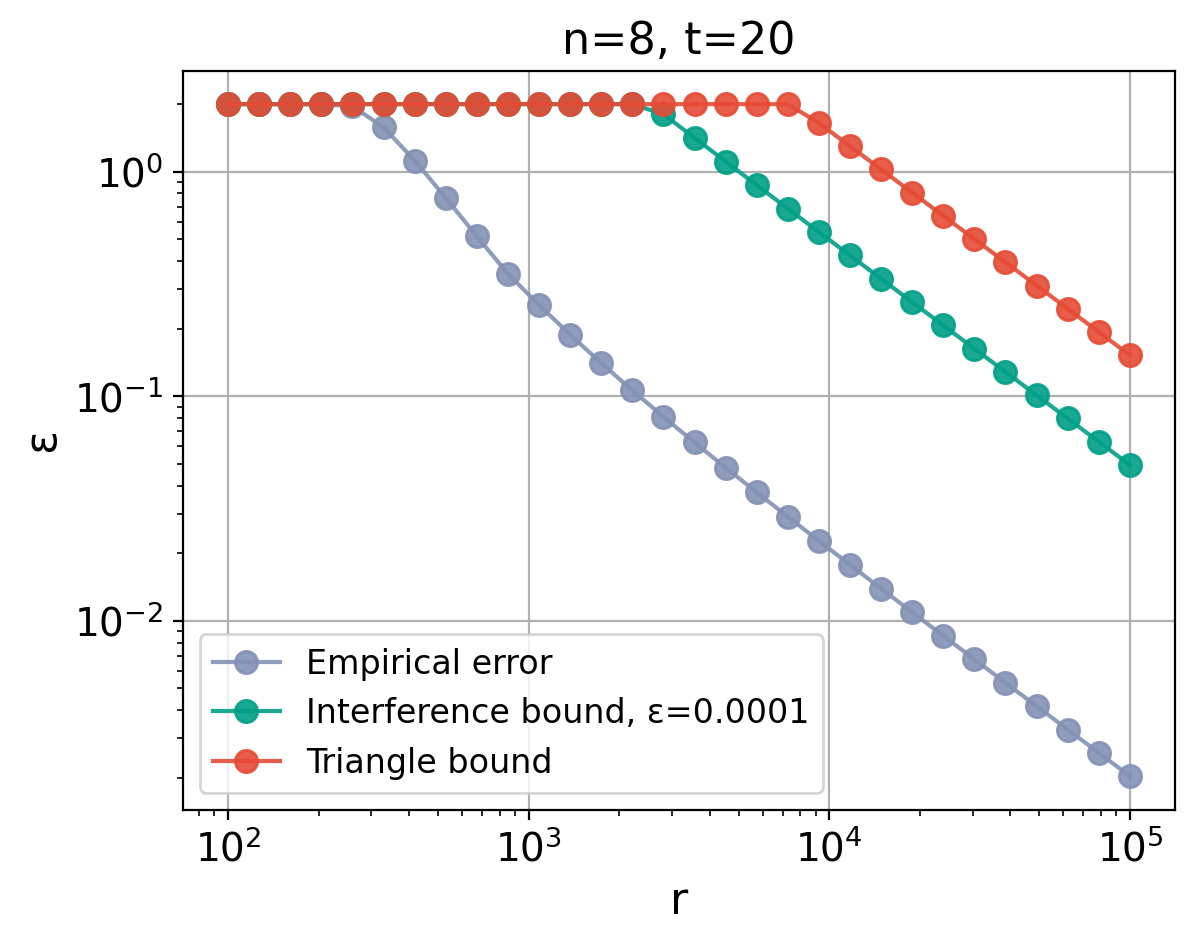

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

color_cycle = ["#8491B4FF", "#00A087FF", "#E64B35FF", "#3C5488FF", "#F39B7FFF", "#7E6148FF", "#4DBBD5FF", "#DC0000FF",  "#91D1C2FF", "#B09C85FF", "#923a3a", "#70699e"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', grid=True, edgecolor='k', prop_cycle=colors)
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.dpi'] = 100

SMALL_SIZE = 12
MEDIUM_SIZE = 14  #default 10
LARGE_SIZE = 16

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 0.0001

emepricial_error = {}
interference_bound = {}
triangle_bound = {}

r_num = 30
logspace_seq = np.logspace(2, 5, num = r_num)
# logspace_seq = np.logspace(4, 9, num = 10)

for i in range(r_num):
    r = round(logspace_seq[i])
    emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    # emepricial_error[r] = trotter_error(H_list, n, T, r)
    interference_bound[r] = min(2, interference_bound_new2(R, H, T) * T*T/r + R2 * T*T*T/(r*r))
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n={n}, t={T}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = f"Interference bound, ε={eps}"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.plot(x_list, y1_list, marker="o", label = y1_title)
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")

In [170]:
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 1
r = 1000000
h = T*T/r
print(h)
eigenvalues, eigenvectors = eig(H)

near_norm = {}
for i in range(-20, 11):
    near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))

interference_R = 0
for i in range(-20, 11):
    interference_R += near_norm[i] * min(1, 1/(2*pi*T*(2**i)))

print(near_norm)
print(interference_R)

print(spectral_norm(expm(-1.0j * H* T - h * R) - expm(-1.0j * H * T))) #emperical error
# print(spectral_norm(near_diagonal(R, eigenvalues, eps)) * h + (spectral_norm(R) - spectral_norm(near_diagonal(R, eigenvalues, eps))) * h / (T * eps)) #interference bound
print(interference_R * h)
print(spectral_norm(R) * h)

0.0004
{-20: 0.0, -19: 0.0, -18: 0.0, -17: 0.0, -16: 0.0, -15: 0.0, -14: 0.0, -13: 0.0, -12: 0.0, -11: 0.0, -10: 0.0, -9: 0.0, -8: 0.0, -7: 8.8, -6: 0.0, -5: 0.0, -4: 0.8664367788756575, -3: 4.419375868779138, -2: 3.1894535369173145, -1: 1.3352687652011639, 0: 2.774002483808644, 1: 2.983441328929718, 2: 4.450334310342825, 3: 5.286452365077555, 4: 3.4405946439588178, 5: 0.5456442739406597, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
9.3643439230543
0.0004055389354541708
0.00374573756922172
0.015236401742332598


In [1002]:
n = 4
t, r = n, 100
dt = t / r

H_list = neighbor_heisenberg(n)
R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
# R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
H = sum(H_list)
HR = H + R * dt / (2j)

HR_eigvals, HR_eigvecs = np.linalg.eigh(HR)[0], np.linalg.eigh(HR)[1]
H_eigvals, H_eigvecs = np.linalg.eigh(H)[0], np.linalg.eigh(H)[1]
print('test correctness of eigen: ', norm(np.dot(H, H_eigvecs[:, 2]) - H_eigvals[2] * H_eigvecs[:, 2], ord=1))
print('HR_eigvals: ', HR_eigvals)
print('H_eigvals: ', H_eigvals)
# print('|HR_eigvals-H_eigvals|: ', norm(HR_eigvals - H_eigvals, ord=1))
# print(norm(HR_eigvals-H_eigvals, ord=2))

eps = 1e-3
dim = 2**n
DR =  np.zeros((dim, dim), dtype=complex)
RR =  np.zeros((dim, dim), dtype=complex)

for j in range(dim):
    for k in range(dim):
        v, u = HR_eigvecs[:, j], HR_eigvecs[:, k]
        b_jk = v.T.conj() @ R @ u
        # print('b_jk: ', b_jk)
        if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
            print(H_eigvals[j], HR_eigvals[k])
            DR += b_jk * v @ u.T.conj()
        else:
            print(H_eigvals[j]-HR_eigvals[k])
            RR += 1/(H_eigvals[j] - HR_eigvals[k]) * b_jk * v @ u.T.conj()

# print(DR, RR)
print(f"||Delta(R)||={norm(DR, ord=2)}, ||R(R)||={norm(RR, ord=2)}")

test correctness of eigen:  2.49479500149234e-15
HR_eigvals:  [-8.03003650e+00 -4.42014790e+00 -3.98028402e+00 -3.60999827e+00
 -5.99262014e-01 -2.87785636e-01 -2.00763647e-01  3.24250366e-16
  2.00763647e-01  2.76789416e-01  5.99262014e-01  3.06544730e+00
  3.60999827e+00  3.94479025e+00  4.42014790e+00  5.01107920e+00]
H_eigvals:  [-8.02981083e+00 -4.41500915e+00 -3.98024805e+00 -3.61500915e+00
 -5.99252348e-01 -2.87318241e-01 -2.00747652e-01 -1.07836911e-16
  2.00747652e-01  2.77394009e-01  5.99252348e-01  3.20000000e+00
  3.61500915e+00  4.01998311e+00  4.41500915e+00  4.80000000e+00]
-8.029810834988577 -8.030036500526638
-3.609662934489827
-4.04952681330796
-4.419812561490382
-7.430548821164219
-7.742025198696156
-7.829047188270079
-8.029810834988577
-8.230574481707077
-8.306600250674283
-8.629072848812935
-11.095258132884618
-11.639809108486777
-11.974601083366316
-12.449958735487327
-13.040890031528763
3.615027347122197
0.005138747094309615
-0.43472513172382365
-0.80501087990624